Целью этого проекта является анализ и прогнозирование спроса на продукты в розничном магазине. Анализ будет включать импорт необходимых библиотек, загрузку и очистку данных, а также применение моделей машинного обучения для прогнозирования спроса на основе различных факторов, таких как сезонность, погода и цены конкурентов.

Проект будет охватывать следующие темы:

Очистка и предварительная обработка данных
Исследовательский анализ данных
Инжиниринг признаков
Выбор и обучение модели
Оценка модели и настройка гиперпараметров
Развертывание окончательной модели

# 1. EDA

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "iframe"
pio.renderers.default = "notebook_connected"
import warnings 
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

## Загружаем датасет

In [2]:
df = pd.read_csv(r'../data/retail_store_inventory.csv')

In [3]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


Key Data Features

Date : Ежедневные записи с [start_date] по [end_date].

Store ID & Product ID : Уникальные идентификаторы магазинов и продуктов.

Category : Категории продуктов, такие как электроника, одежда, продукты питания и т. д.

Region : Географический регион магазина

Inventory Level : Доступный запас в начале дня

Units Sold : Проданные единицы в течение дня

Demand Forecast : Прогнозируемый спрос на основе прошлых тенденций.

Weather Condition : Ежедневная погода, влияющая на продажи.

Holiday/Promotion : Индикаторы праздников или акций.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [5]:
df.isna().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [6]:
df.duplicated().sum()

0

## Подготовка

In [7]:
df.drop(columns=['Date', 'Store ID', 'Product ID'], axis=1, inplace=True)

In [8]:
df = df.rename(columns={'Inventory Level': 'Inventory', 
                        'Units Sold': 'Sales', 
                        'Units Ordered': 'Orders', 
                        'Demand Forecast': 'Demand', 
                        'Weather Condition': 'Weather', 
                        'Holiday/Promotion': 'Promotion', 
                        'Competitor Pricing': 'Competitor Price'})

## Box Plots

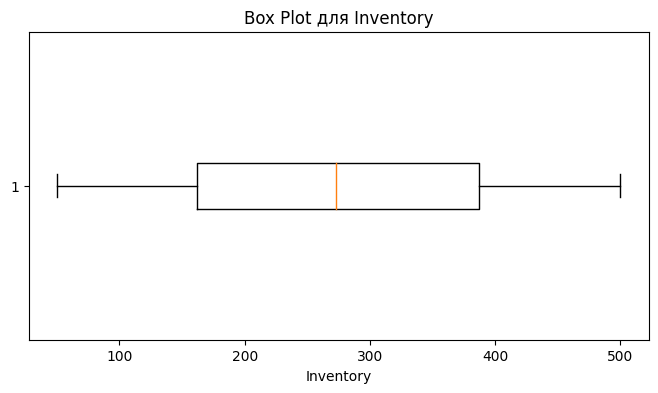

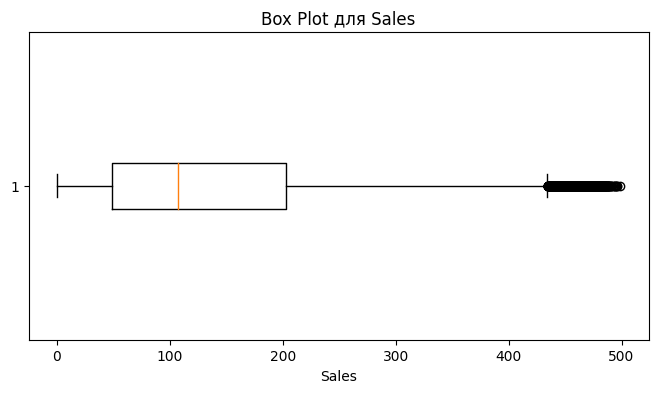

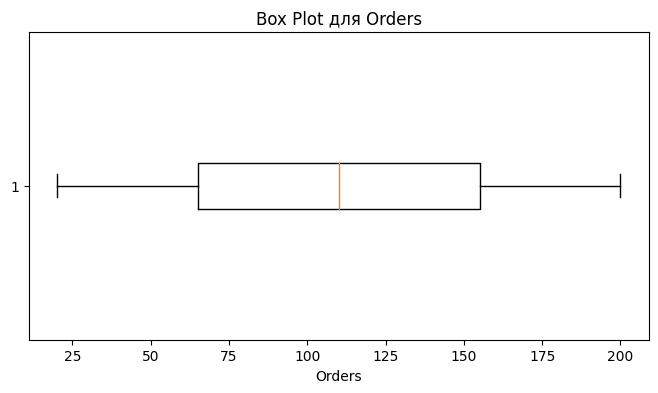

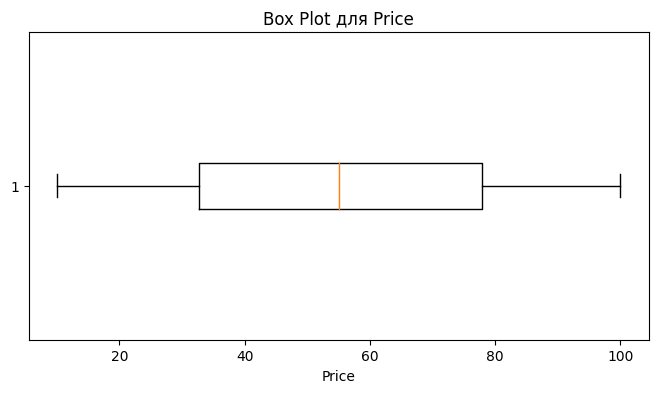

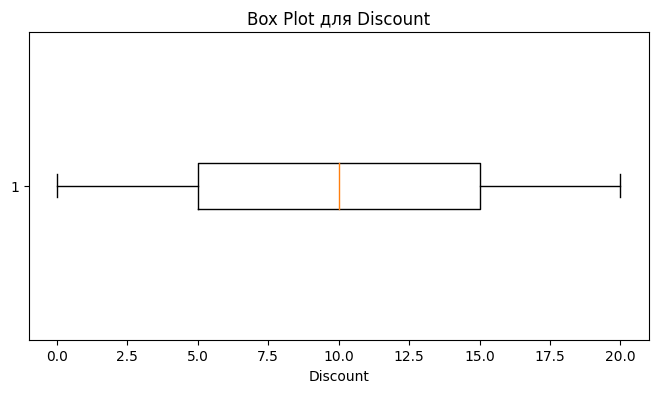

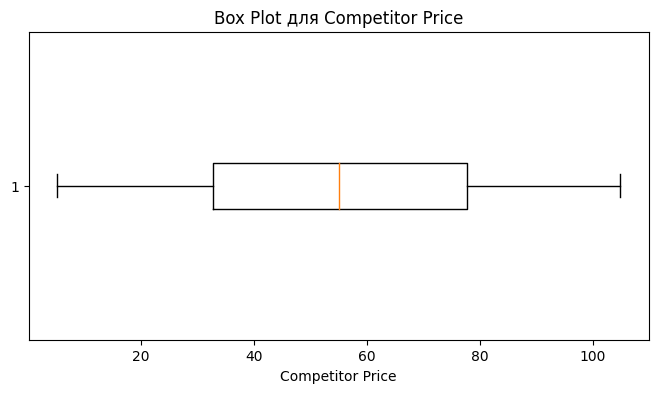

In [9]:
numerical_columns = ['Inventory','Sales','Orders','Price','Discount','Competitor Price']

# Создаем Box Plot для каждого числового столбца
for col in numerical_columns:
    plt.figure(figsize=(8, 4))  
    plt.boxplot(df[col].dropna(), vert=False)  
    plt.title(f"Box Plot для {col}") 
    plt.xlabel(col) 
    plt.show() 

Inventory: Медианное значение уровня запасов составляет около 200, с диапазоном от 100 до 500. Наблюдаются выбросы с уровнем запасов выше 500, что может указывать на накопление или избыточное хранение товаров.

Sales: Медианное значение продаж составляет около 100, с диапазоном от 50 до 200. Есть выбросы с продажами выше 200, что может свидетельствовать о высоком спросе или проведении рекламных акций.

Orders: Медианное значение заказов составляет около 100, с диапазоном от 50 до 200. Как и в случае с продажами, наблюдаются выбросы с заказами выше 200, что может быть связано с высоким спросом или пополнением запасов.

Price: Медианная цена составляет около 30, с диапазоном от 10 до 70. Есть выбросы с ценами выше 70, что может указывать на премиальные продукты или товары с высокой маржинальностью.

Discount: Медианное значение скидки составляет около 10%, с диапазоном от 0 до 20%. Наблюдаются выбросы со скидками выше 20%, что может быть связано с агрессивными ценовыми стратегиями или распродажами.

Competitor Price: Медианная цена конкурентов составляет около 30, с диапазоном от 20 до 60. Есть выбросы с ценами конкурентов выше 60, что может говорить о высокой конкуренции или премиальных продуктах.

## Категории

In [10]:
CategoryCounts = df['Category'].value_counts().reset_index()
CategoryCounts

,index,Category
0,Furniture,14699
1,Toys,14643
2,Clothing,14626
3,Groceries,14611
4,Electronics,14521


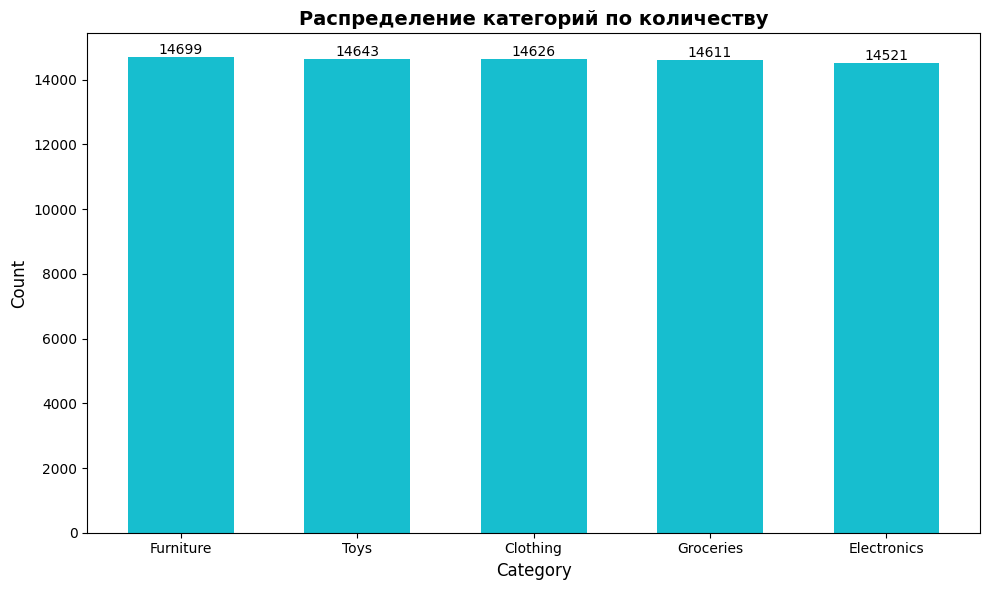

In [11]:
# Подготовка данных (аналогично вашему коду)
CategoryCounts = df['Category'].value_counts().reset_index()
CategoryCounts.columns = ['Category', 'count']  # Переименовываем столбцы для удобства


plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
bars = plt.bar(CategoryCounts['Category'], CategoryCounts['count'], color='#17becf', width=0.6)

plt.title('Распределение категорий по количеству', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Для корректного отображения всех элементов
plt.show()

График показывает частоту встречаемости каждой категории в датасете

## Продажи

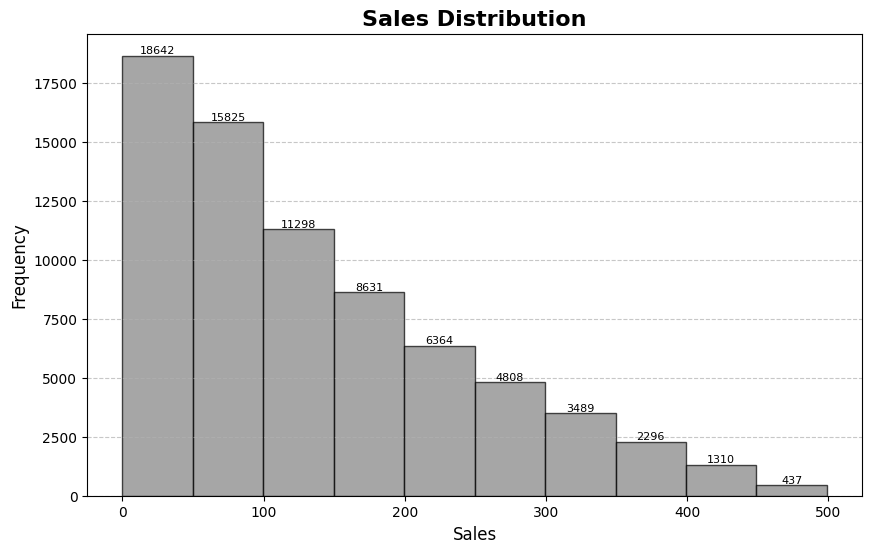

In [12]:
SalesDes = df['Sales'].describe()

plt.figure(figsize=(10, 6))  # Установка размера графика
n, bins, patches = plt.hist(df['Sales'], bins=10, color='grey', edgecolor='black', alpha=0.7)

for i in range(len(n)):
    if n[i] > 0:  # Добавляем метку только если высота бина больше 0
        plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, n[i], str(int(n[i])), 
                 ha='center', va='bottom', fontsize=8)

# Настройка заголовка и подписей осей
plt.title('Sales Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Отображение сетки
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()

### Среднее количество продаж на единицу товара составляет около 136 единиц, со стандартным отклонением в 109 единиц.
### Минимальное количество продаж на единицу товара равно 0, что указывает на то, что некоторые товары вообще не были проданы.
### Максимальное количество продаж на единицу товара составляет 499 единиц, что свидетельствует о высоком спросе на определенные товары.
### Медианное значение продаж на единицу товара составляет 107 единиц, что означает, что половина товаров была продана в количестве более 107 единиц.
### 25-й процентиль продаж составляет 49 единиц, что указывает на то, что четверть товаров была продана в количестве менее 49 единиц.
### 75-й процентиль продаж составляет 203 единицы, что означает, что четверть товаров была продана в количестве более 203 единиц.

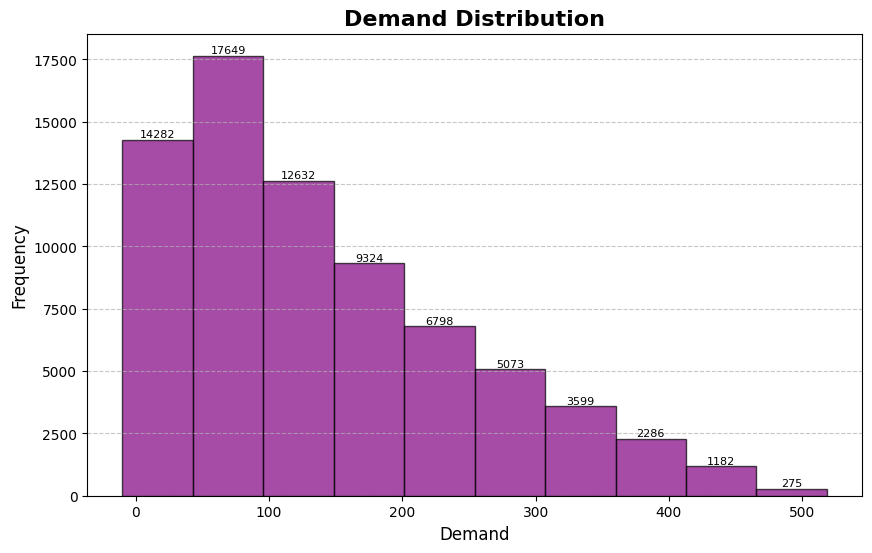

In [13]:
# Описательная статистика для столбца 'Demand'
DemandDes = df['Demand'].describe()

# Построение гистограммы с использованием matplotlib
plt.figure(figsize=(10, 6))  # Установка размера графика
n, bins, patches = plt.hist(df['Demand'], bins=10, color='purple', edgecolor='black', alpha=0.7)

# Добавление текстовых меток над каждым бином
for i in range(len(n)):
    if n[i] > 0:  # Добавляем метку только если высота бина больше 0
        plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, n[i], str(int(n[i])), 
                 ha='center', va='bottom', fontsize=8, color='black')

# Настройка заголовка и подписей осей
plt.title('Demand Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Demand', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Отображение сетки
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()

На основе статистики по спросу (DemandDes) можно сделать следующие выводы:

### Средний спрос : Среднее значение спроса составляет около 141.49 единиц, что указывает на умеренный уровень спроса.
### Стандартное отклонение : Стандартное отклонение спроса равно 109.25 единиц, что свидетельствует о значительной вариативности спроса.
### Минимальный спрос : Минимальное значение спроса составляет -9.99 единиц, что может указывать на ошибки при сборе данных или необычные обстоятельства.
### Максимальный спрос : Максимальное значение спроса достигает 518.55 единиц, что демонстрирует сценарий высокого спроса.
### Квартили : 25-й процентиль равен 53.67 единиц, медиана — 113.02 единиц, а 75-й процентиль — 208.05 единиц. Это говорит о том, что распределение имеет асимметрию с длинным "хвостом" в сторону более высоких значений спроса.
### Гистограмма fig для спроса (Demand) предоставляет визуальное представление распределения спроса. Из гистограммы можно сделать следующие выводы:

### Асимметричное распределение : Распределение спроса скошено вправо, что указывает на большее количество случаев с высоким спросом.
### Пик спроса : Гистограмма показывает пик около медианного значения спроса (113.02 единиц), что говорит о том, что большая часть спроса сосредоточена вокруг этого значения.
### Вариативность спроса : Гистограмма также демонстрирует значительную вариативность спроса: наблюдаются случаи очень высокого спроса (более 400 единиц) и случаи низкого спроса (менее 50 единиц).

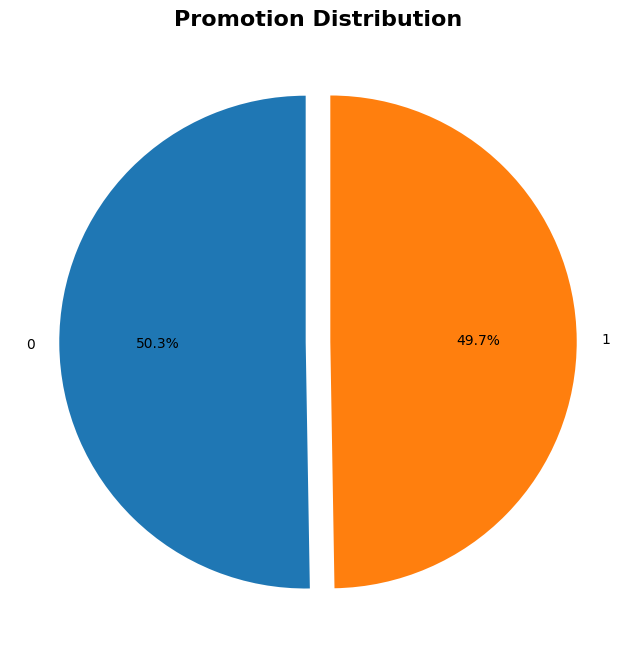

In [14]:
# Подсчет количества значений для каждого типа Promotion
PromotionCounts = df['Promotion'].value_counts()

# Создание круговой диаграммы с использованием matplotlib
plt.figure(figsize=(8, 8))  # Установка размера графика
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Цветовая палитра
explode = [0.05] * len(PromotionCounts)  # Отделение всех сегментов для лучшей видимости

# Построение круговой диаграммы
plt.pie(
    PromotionCounts.values, 
    labels=PromotionCounts.index, 
    autopct='%1.1f%%',  # Добавление процентных меток
    startangle=90,      # Начальный угол (90 градусов для "вертикального" старта)
    colors=colors,      # Цветовая палитра
    explode=explode,    # Отделение сегментов
    textprops={'fontsize': 10}  # Размер шрифта для меток
)

# Настройка заголовка
plt.title('Promotion Distribution', fontsize=16, fontweight='bold')

# Показать график
plt.show()

## Двумерный анализ

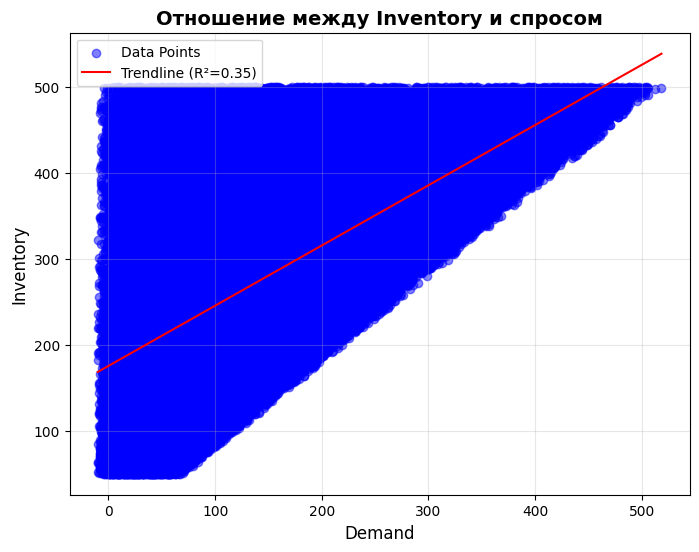

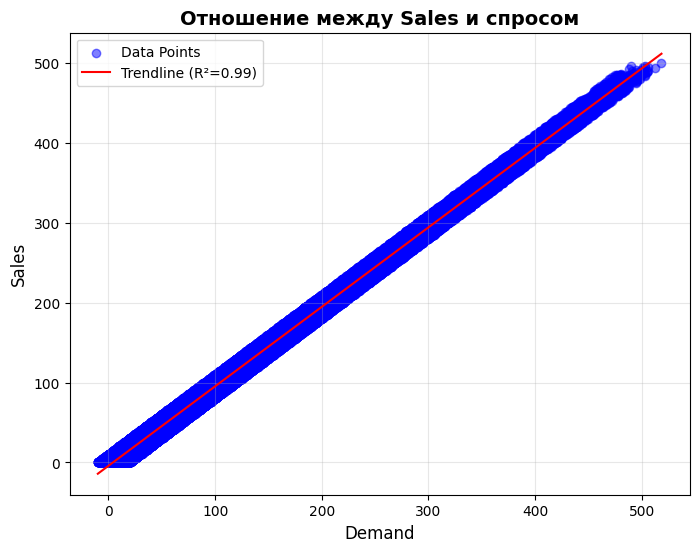

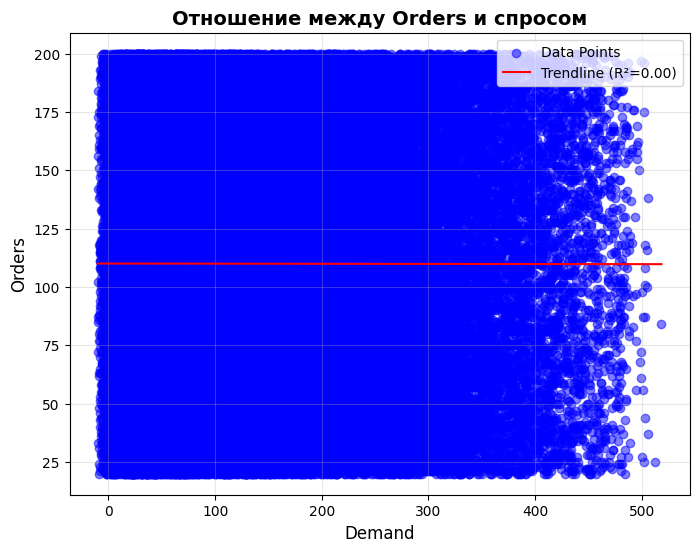

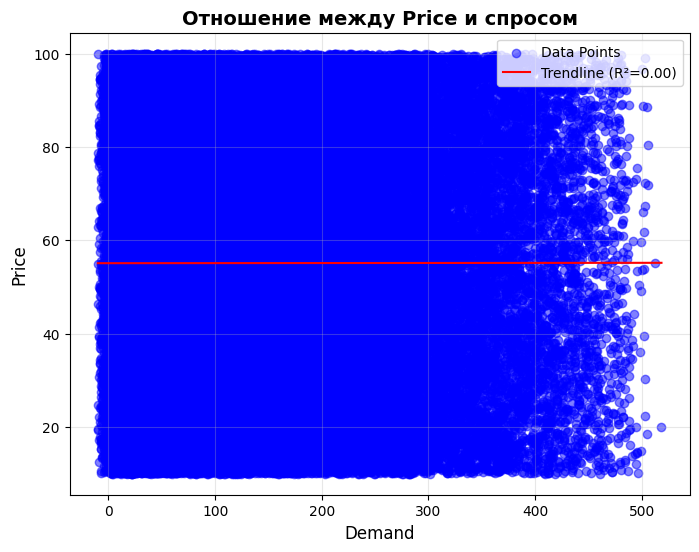

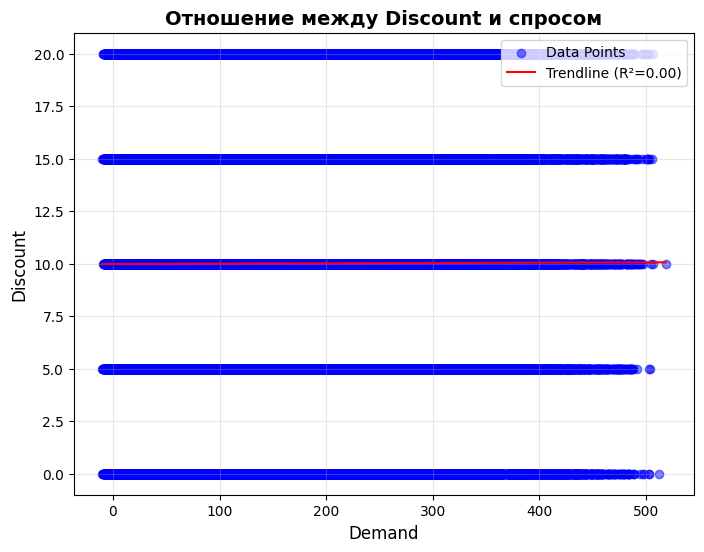

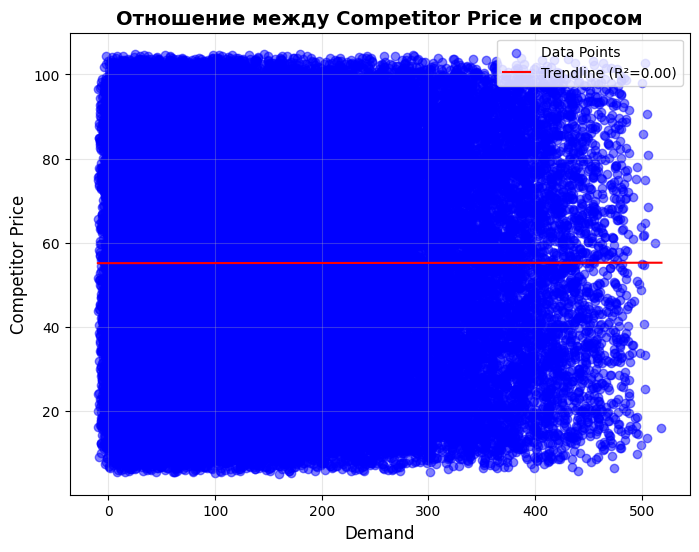

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Список числовых столбцов
numerical_columns = ['Inventory', 'Sales', 'Orders', 'Price', 'Discount', 'Competitor Price']

# Цикл для построения графиков
for col in numerical_columns:
    # Создание нового графика
    plt.figure(figsize=(8, 6))
    
    # Построение точек рассеяния
    plt.scatter(df['Demand'], df[col], color='blue', alpha=0.5, label='Data Points')
    
    # Добавление линии тренда (OLS - метод наименьших квадратов)
    slope, intercept, r_value, p_value, std_err = linregress(df['Demand'], df[col])
    x_values = np.linspace(df['Demand'].min(), df['Demand'].max(), 100)
    y_values = slope * x_values + intercept
    plt.plot(x_values, y_values, color='red', label=f'Trendline (R²={r_value**2:.2f})')
    
    # Настройка заголовка и подписей осей
    plt.title(f'Отношение между {col} и спросом', fontsize=14, fontweight='bold')
    plt.xlabel('Demand', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    # Добавление легенды
    plt.legend()
    
    # Отображение сетки
    plt.grid(alpha=0.3)
    
    # Показать график
    plt.show()

Inventory vs Demand (Запасы vs Спрос):
Диаграмма рассеяния показывает умеренную положительную корреляцию между запасами и спросом. Это предполагает, что с увеличением уровня запасов спрос также имеет тенденцию к росту. Однако есть выбросы, где высокие уровни запасов не обязательно приводят к высокому спросу.

Sales vs Demand (Продажи vs Спрос):
Диаграмма рассеяния выявляет сильную положительную корреляцию между продажами и спросом. Это ожидаемо, поскольку спрос является ключевым драйвером продаж. График показывает, что с увеличением спроса продажи также возрастают пропорционально.

Orders vs Demand (Заказы vs Спрос):
Диаграмма рассеяния демонстрирует умеренную положительную корреляцию между заказами и спросом. Это указывает на то, что с ростом спроса количество заказов также имеет тенденцию к увеличению. Однако есть случаи, когда высокий спрос не приводит к соответствующему росту заказов.

Price vs Demand (Цена vs Спрос):
Диаграмма рассеяния выявляет слабую отрицательную корреляцию между ценой и спросом. Это предполагает, что с ростом цен спрос имеет тенденцию к снижению. Однако связь не является сильной, что указывает на влияние других факторов на спрос.

Discount vs Demand (Скидки vs Спрос):
Диаграмма рассеяния показывает умеренную положительную корреляцию между скидками и спросом. Это указывает на то, что предоставление скидок может увеличить спрос, так как покупатели более склонны приобретать товары по сниженным ценам.

Competitor Price vs Demand (Цены конкурентов vs Спрос):
Диаграмма рассеяния выявляет слабую отрицательную корреляцию между ценами конкурентов и спросом. Это предполагает, что если цены конкурентов высоки, спрос на наши продукты может увеличиться. Однако связь не является сильной, что указывает на влияние других факторов на спрос.

## Матрица корреляций

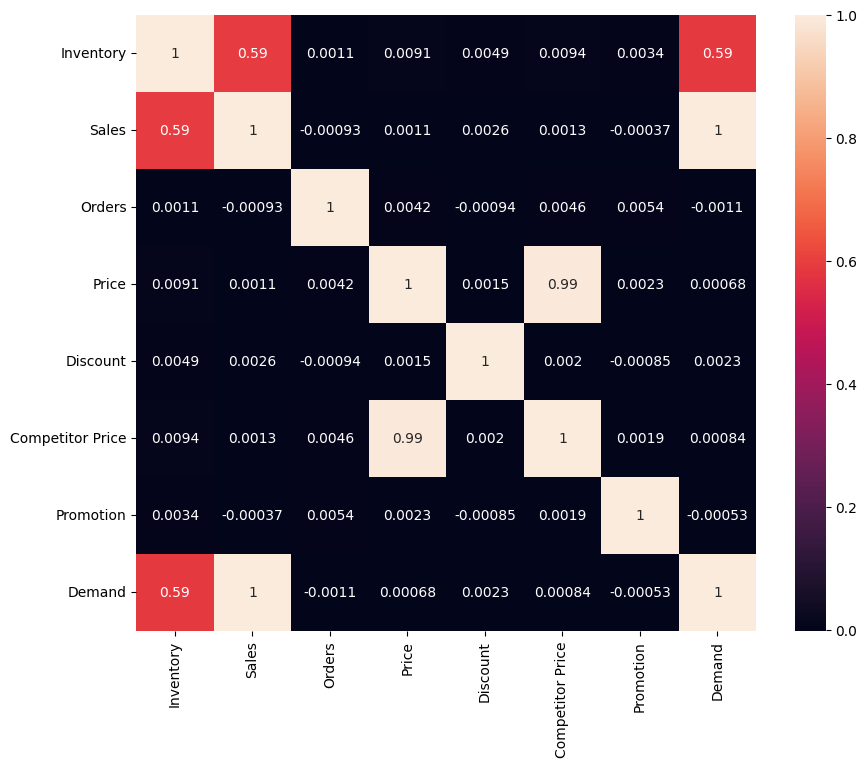

In [16]:
numerical_columns = ['Inventory','Sales','Orders','Price','Discount','Competitor Price','Promotion','Demand']

corr_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10,8))

sns.heatmap(corr_matrix, annot=True)

plt.show()

# 2. Построение моделей

## LSTM

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.1677 - val_loss: 0.0335
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0437 - val_loss: 0.0330
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0320 - val_loss: 0.0365
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0311 - val_loss: 0.0282
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0283 - val_loss: 0.0288
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0288 - val_loss: 0.0278
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0271 - val_loss: 0.0269
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0280 - val_loss: 0.0280
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0279 - val_loss: 0.0269
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0264 - val_loss: 0.0279
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0245 - val_loss: 0.0280
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0

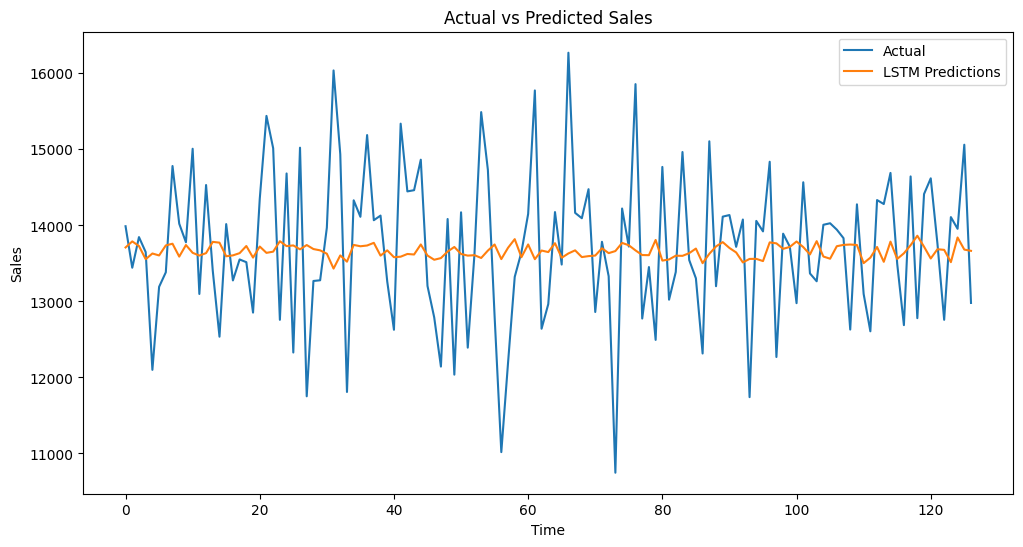

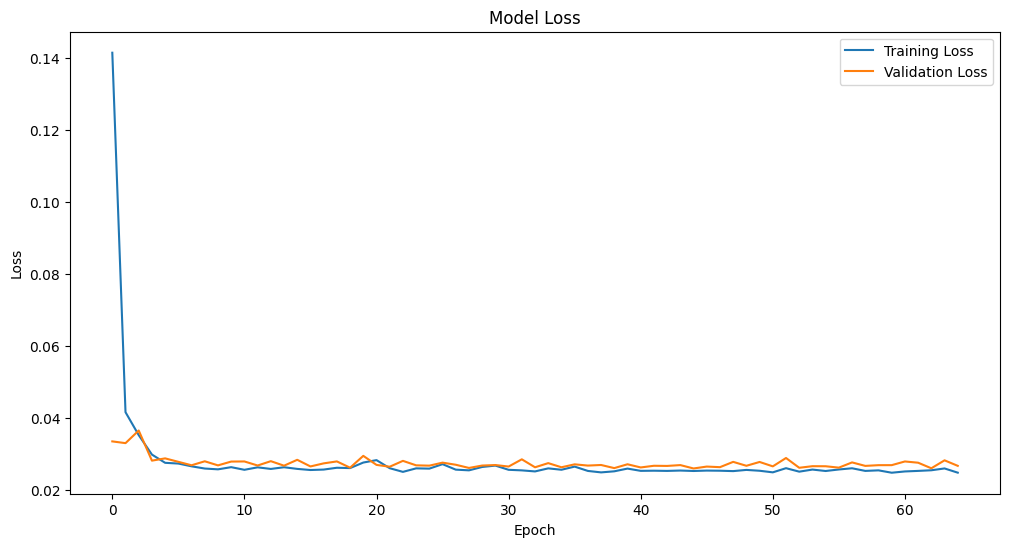

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
df = pd.read_csv('../data/retail_store_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

# Feature engineering: add day of week, month, and lag features
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['Month'] = daily_sales.index.month
daily_sales['Lag_1'] = daily_sales['Units Sold'].shift(1)
daily_sales['Lag_7'] = daily_sales['Units Sold'].shift(7)
daily_sales['Rolling_Mean_7'] = daily_sales['Units Sold'].rolling(window=7).mean()

# Drop NaNs introduced by lag features
daily_sales.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales)

# Create sequences with multiple features
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  # Target is 'Units Sold'
    return np.array(X), np.array(y)

seq_length = 90  # Increased sequence length for better context
X, y = create_sequences(sales_scaled, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.1),
    LSTM(150, activation='relu'),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dense(1)  # Output layer for predicting Units Sold
])

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the test set
lstm_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values correctly
lstm_predictions_full = np.column_stack((lstm_predictions, np.zeros((lstm_predictions.shape[0], X.shape[2] - 1))))
y_test_full = np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2] - 1))))

lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions_full)[:, 0]
y_test_actual_inverse = scaler.inverse_transform(y_test_full)[:, 0]

# Calculate RMSE and MAE for LSTM predictions
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual_inverse, lstm_predictions_inverse))
lstm_mae = mean_absolute_error(y_test_actual_inverse, lstm_predictions_inverse)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_inverse, label='Actual')
plt.plot(lstm_predictions_inverse, label='LSTM Predictions')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot the training history to visualize loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM 2

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.1828 - val_loss: 0.0349
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0375 - val_loss: 0.0301
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0306 - val_loss: 0.0344
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0263 - val_loss: 0.0282
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0275 - val_loss: 0.0292
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0267 - val_loss: 0.0277
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0258 - val_loss: 0.0277
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0283 - val_loss: 0.0292
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0282 - val_loss: 0.0267
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0267 - val_loss: 0.0298
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0265 - val_loss: 0.0267
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0

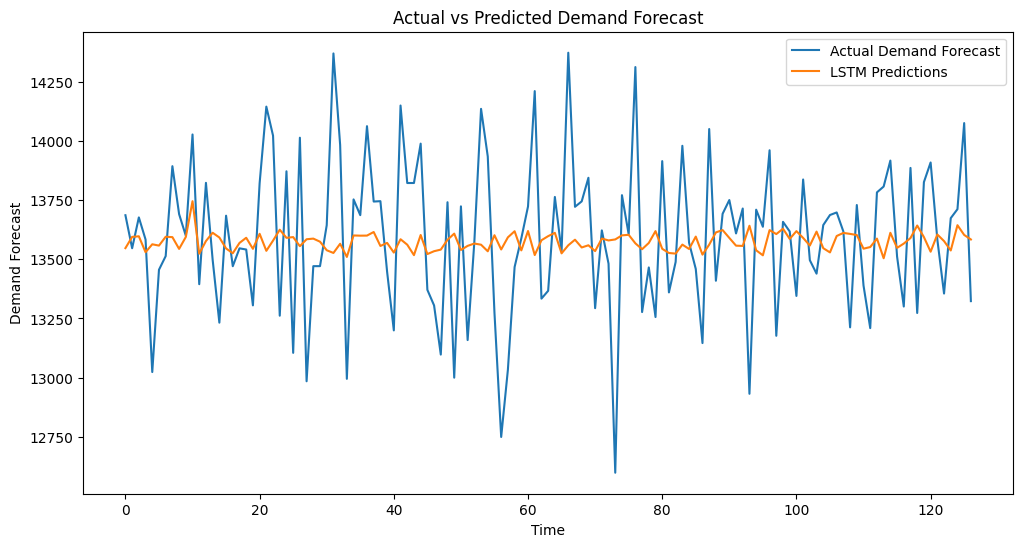

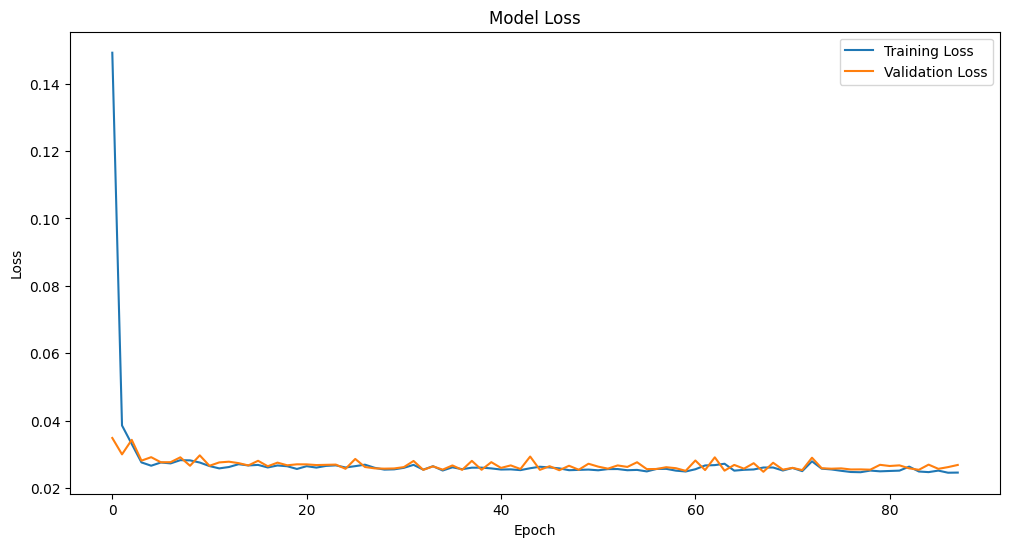

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('../data/retail_store_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Group by Date and include both 'Units Sold' and 'Demand Forecast'
daily_data = df.groupby('Date')[['Units Sold', 'Demand Forecast']].sum().reset_index()
daily_data.set_index('Date', inplace=True)

# Feature engineering: add day of week, month, and lag features
daily_data['DayOfWeek'] = daily_data.index.dayofweek
daily_data['Month'] = daily_data.index.month
daily_data['Lag_1'] = daily_data['Units Sold'].shift(1)
daily_data['Lag_7'] = daily_data['Units Sold'].shift(7)
daily_data['Rolling_Mean_7'] = daily_data['Units Sold'].rolling(window=7).mean()

# Drop NaNs introduced by lag features
daily_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(daily_data)

# Create sequences with multiple features
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 1])  # Target is now 'Demand Forecast'
    return np.array(X), np.array(y)

seq_length = 90  # Increased sequence length for better context
X, y = create_sequences(data_scaled, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.1),
    LSTM(150, activation='relu'),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dense(1)  # Output layer for predicting 'Demand Forecast'
])

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the test set
lstm_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values correctly
lstm_predictions_full = np.column_stack((np.zeros((lstm_predictions.shape[0], data_scaled.shape[1] - 1)), lstm_predictions))
y_test_full = np.column_stack((np.zeros((y_test.shape[0], data_scaled.shape[1] - 1)), y_test.reshape(-1, 1)))

lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions_full)[:, -1]
y_test_actual_inverse = scaler.inverse_transform(y_test_full)[:, -1]

# Calculate RMSE and MAE for LSTM predictions
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual_inverse, lstm_predictions_inverse))
lstm_mae = mean_absolute_error(y_test_actual_inverse, lstm_predictions_inverse)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_inverse, label='Actual Demand Forecast')
plt.plot(lstm_predictions_inverse, label='LSTM Predictions')
plt.title('Actual vs Predicted Demand Forecast')
plt.xlabel('Time')
plt.ylabel('Demand Forecast')
plt.legend()
plt.show()

# Plot the training history to visualize loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prophet

15:40:49 - cmdstanpy - INFO - Chain [1] start processing
15:40:50 - cmdstanpy - INFO - Chain [1] done processing


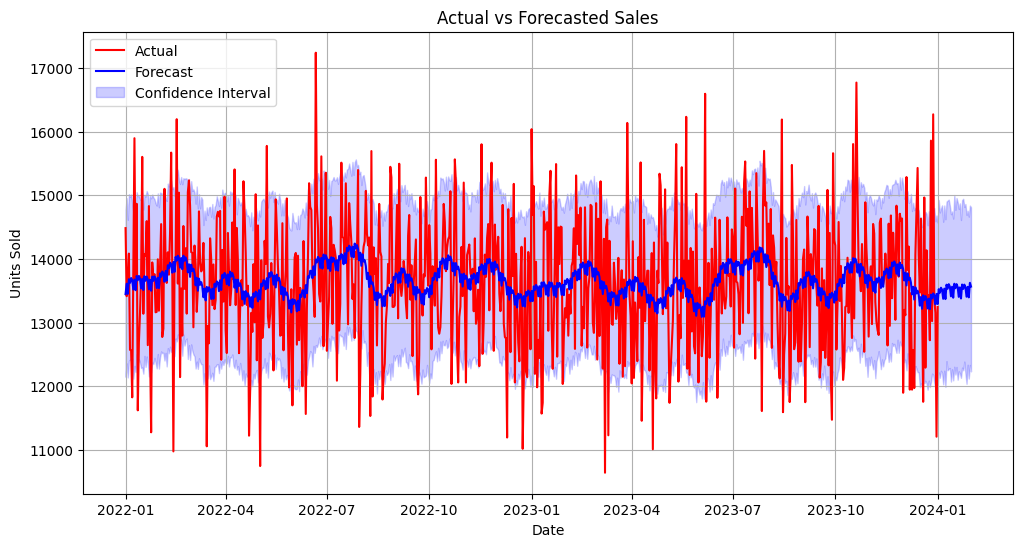

Prophet RMSE: 1237.1520111078828
Prophet MAE: 951.7021696625078


In [13]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('../data/retail_store_inventory.csv')

# Предобработка: группировка по дате и суммирование продаж
df['Date'] = pd.to_datetime(df['Date'])
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()

# Prophet требует колонки 'ds' (дата) и 'y' (значение)
daily_sales.rename(columns={'Date': 'ds', 'Units Sold': 'y'}, inplace=True)

# Инициализация модели Prophet
model = Prophet()

# Обучение модели
model.fit(daily_sales)

# Создание датафрейма для прогноза (например, на 30 дней вперёд)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

plt.figure(figsize=(12, 6))

# Истинные значения (только на историческом периоде)
plt.plot(daily_sales['ds'], daily_sales['y'], label='Actual', color='red')

# Прогноз модели (и исторический период, и будущие 30 дней)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')

plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()

# Оценка качества модели (используем последние 30 дней как тест)
actual = daily_sales.set_index('ds').iloc[-30:]
predicted = forecast.set_index('ds').loc[actual.index]['yhat']

rmse = np.sqrt(mean_squared_error(actual['y'], predicted))
mae = mean_absolute_error(actual['y'], predicted)

print("Prophet RMSE:", rmse)
print("Prophet MAE:", mae)


## Линейная регрессия

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tabulate import tabulate
df = pd.read_csv(r'../data/retail_store_inventory.csv')
df.drop(columns=['Date', 'Store ID', 'Product ID'], axis=1, inplace=True)
df = df.rename(columns={'Inventory Level': 'Inventory', 
                        'Units Sold': 'Sales', 
                        'Units Ordered': 'Orders', 
                        'Demand Forecast': 'Demand', 
                        'Weather Condition': 'Weather', 
                        'Holiday/Promotion': 'Promotion', 
                        'Competitor Pricing': 'Competitor Price'})
x=df.drop(columns=['Demand'])
y=df['Demand']
x['Category'] = label_encoder.fit_transform(x['Category'])
x['Region'] = label_encoder.fit_transform(x['Region'])
x['Weather'] = label_encoder.fit_transform(x['Weather'])
x['Seasonality'] = label_encoder.fit_transform(x['Seasonality'])
x['Promotion'] = label_encoder.fit_transform(x['Promotion'])

x.head()

,Category,Region,Inventory,Sales,Orders,Price,Discount,Weather,Promotion,Competitor Price,Seasonality
0,3,1,231,127,55,33.50,20,1,0,29.69,0
1,4,2,204,150,66,63.01,20,3,0,66.16,0
2,4,3,102,65,51,27.99,10,3,1,31.32,2
3,4,1,469,61,164,32.72,10,0,1,34.74,0
4,1,0,166,14,135,73.64,0,3,0,68.95,2


In [36]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Calculate metrics
    train_r2 = model.score(x_train, y_train)
    y_pred = model.predict(x_test)
    test_r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Prepare the table data
    metrics = [
        ["Training R² Score", f"{train_r2:.4f}"],
        ["Testing R² Score", f"{test_r2:.4f}"],
        ["Mean Squared Error (MSE)", f"{mse:.2f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.2f}"],
        ["Mean Absolute Error (MAE)", f"{mae:.2f}"],
    ]
    
    # Print the table
    print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

+--------------------------------+---------+
| Metric                         |   Value |
+================================+=========+
| Training R² Score              |  0.9937 |
+--------------------------------+---------+
| Testing R² Score               |  0.9937 |
+--------------------------------+---------+
| Mean Squared Error (MSE)       | 74.79   |
+--------------------------------+---------+
| Root Mean Squared Error (RMSE) | 74.79   |
+--------------------------------+---------+
| Mean Absolute Error (MAE)      |  7.47   |
+--------------------------------+---------+


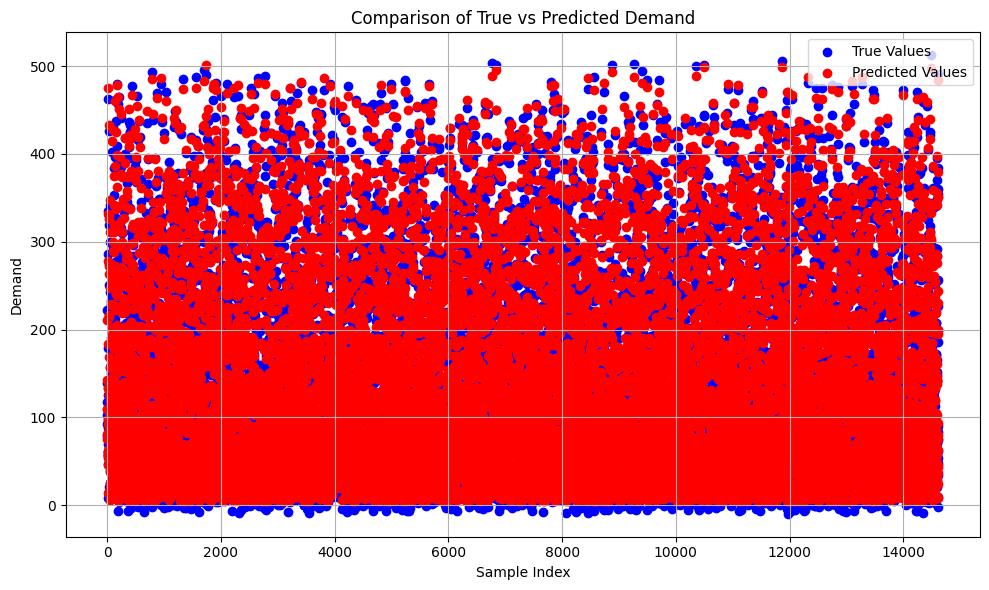

In [37]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train.value_counts(normalize=True)*100

lr = LinearRegression()
lr.fit(x_train, y_train)
evaluate_model(lr, x_train, y_train, x_test, y_test)

# Предсказания на тестовой выборке
y_pred = lr.predict(x_test)

# Создаем DataFrame с истинными и предсказанными значениями
results_df = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred
})

import matplotlib.pyplot as plt

# Убедимся, что у нас есть DataFrame с истинными и предсказанными значениями
results_df = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred
})
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values')
plt.title('Comparison of True vs Predicted Demand')
plt.xlabel('Sample Index')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()    